In [1]:
from functools import partial
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import optuna
import shap
import warnings

warnings.filterwarnings('ignore')

E:\dsls 2023\New folder\dsls-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get Data

In [2]:
jams = pd.read_csv('./../dataset/jams_bogor.csv')
jams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102322 entries, 0 to 102321
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   level             102322 non-null  int64  
 1   median_length     102322 non-null  float64
 2   median_delay      102322 non-null  float64
 3   median_speed_kmh  102322 non-null  float64
 4   total_records     102322 non-null  int64  
 5   isWeekend         102322 non-null  int64  
 6   longitude         102322 non-null  float64
 7   latitude          102322 non-null  float64
 8   isRushHour        102322 non-null  int64  
 9   hour_sin          102322 non-null  float64
 10  hour_cos          102322 non-null  float64
 11  day_sin           102322 non-null  float64
 12  day_cos           102322 non-null  float64
 13  week_sin          102322 non-null  float64
 14  week_cos          102322 non-null  float64
 15  month_sin         102322 non-null  float64
 16  month_cos         10

In [3]:
# Sorting Columns
col_feature = list(set(jams.columns) - set(['level']))
col_feature.sort() 

features = jams[col_feature].copy()
labels = jams['level'].copy()

In [4]:
X_train = features.loc[jams.is_train==1]
y_train = labels.loc[jams.is_train==1]
X_test = features.loc[jams.is_train==0]
y_test = labels.loc[jams.is_train==0]

y_test.value_counts()  / y_test.shape[0] * 100

1    54.132326
2    30.335212
3    15.532462
Name: level, dtype: float64

## Hyperparameter Tuning with Optuna

In [5]:

def objective(trial, X, y):

    # parameter space
    sm_neighbors = trial.suggest_int('sm_neighbors', 3, 9)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 5, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 9)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 7)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    # sm = SMOTE()
    sm = SMOTE(k_neighbors = sm_neighbors, random_state = 123)
    X_sm, y_sm = sm.fit_resample(X, y)
    
    model = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, class_weight=class_weight, random_state=123)
    
    f1_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    for train_idx, val_idx in skf.split(X, y):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        X_sm, y_sm = sm.fit_resample(X_train, y_train)
        model.fit(X_sm, y_sm)

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='macro')
        f1_scores.append(f1)


    return np.mean(f1_scores)

In [6]:
optimize_func = partial(objective, X=X_train, y=y_train)

study = optuna.create_study(direction='maximize')
study.optimize(optimize_func, n_trials=100)

[I 2023-03-01 19:36:41,457] A new study created in memory with name: no-name-08e20108-52f2-4b4c-8708-af77ebbe35c1
[I 2023-03-01 19:36:51,706] Trial 0 finished with value: 0.8522965350731504 and parameters: {'sm_neighbors': 6, 'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 7, 'class_weight': None}. Best is trial 0 with value: 0.8522965350731504.
[I 2023-03-01 19:36:59,306] Trial 1 finished with value: 0.7999398085654417 and parameters: {'sm_neighbors': 5, 'criterion': 'log_loss', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'class_weight': None}. Best is trial 0 with value: 0.8522965350731504.
[I 2023-03-01 19:37:11,917] Trial 2 finished with value: 0.8598501813265351 and parameters: {'sm_neighbors': 9, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 6, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8598501813265351.
[I 2023-03-01 19:37:19,847] Trial 3 finished with value: 0.8000503

In [7]:
trial = study.best_trial
best_param = trial.params

print('F1-Macro: {}'.format(trial.value))
print("Best hyperparameters: {}".format(best_param))

F1-Macro: 0.8648601492843351
Best hyperparameters: {'sm_neighbors': 5, 'criterion': 'log_loss', 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 5, 'class_weight': 'balanced'}


## Training Model & Evaluation

In [8]:
def calculate_metrics_score(y_true, y_pred):
    print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

In [9]:
sm = SMOTE(k_neighbors=best_param['sm_neighbors'], random_state=123)
model = DecisionTreeClassifier(criterion=best_param['criterion'], max_depth=best_param['max_depth'], min_samples_split=best_param['min_samples_split'],
                                   min_samples_leaf=best_param['min_samples_leaf'], class_weight=best_param['class_weight'], random_state=123)
    

X_sm, y_sm = sm.fit_resample(X_train, y_train)
model.fit(X_sm, y_sm)

calculate_metrics_score(y_sm, model.predict(X_sm))

Confusion Matrix:
 [[37424  1239   111]
 [ 1305 36197  1272]
 [   80   984 37710]]
              precision    recall  f1-score   support

           1       0.96      0.97      0.96     38774
           2       0.94      0.93      0.94     38774
           3       0.96      0.97      0.97     38774

    accuracy                           0.96    116322
   macro avg       0.96      0.96      0.96    116322
weighted avg       0.96      0.96      0.96    116322



In [10]:
y_pred = model.predict(X_test)
calculate_metrics_score(y_test, y_pred)

Confusion Matrix:
 [[15382  1148    87]
 [  865  7739   708]
 [   44   550  4174]]
              precision    recall  f1-score   support

           1       0.94      0.93      0.93     16617
           2       0.82      0.83      0.83      9312
           3       0.84      0.88      0.86      4768

    accuracy                           0.89     30697
   macro avg       0.87      0.88      0.87     30697
weighted avg       0.89      0.89      0.89     30697



In [14]:
model_file = '../model/model_2.pkl'

# joblib.dump(model, model_file)
model_load = joblib.load(model_file)

## Feature Importance

In [12]:
explainer = shap.TreeExplainer(model_load,)
shap_values = explainer.shap_values(X_sm)

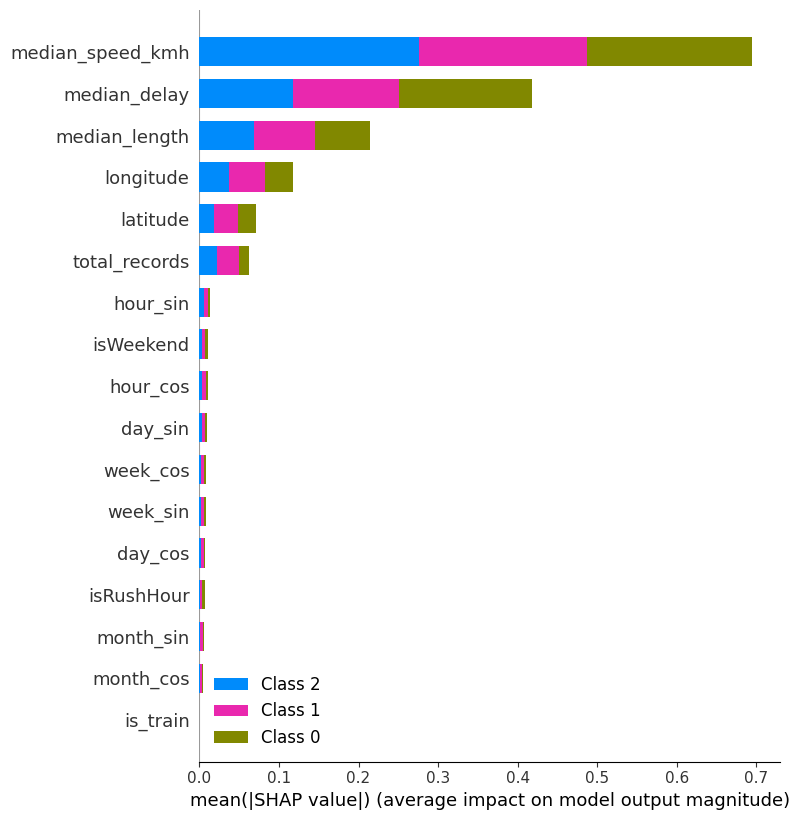

In [13]:
shap.summary_plot(shap_values, X_sm, plot_type="bar")

>Nilai median_speed_kmh, median_delay dan median_length memiliki pengaruh yang kuat dalam menentukan hasil prediksi